# Final Project

*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Vanessa Roser
* Declan Campbell
* Yunchang Zhang

---

## Sparse Interactions

### Preparation (3pts)

Review the paper [The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions](https://arxiv.org/abs/1905.06501) by Agrawal et al. (2019). Start with the general concepts and then go into the finer details.

When you feel comfortable with the content, answer the following questions:

1. Why does the Gaussian scale mixture prior promote sparsity of the regression coefficients $\theta$?
2. What are the required properties of the model in Eq. (3) that allow it to be rewritten in the form of Eq. (6)?
3. What are the conceptual and practical limitation of the approach?

**Hint:** Some of the answers may require parsing the relevant references.

1. The priors of the regression coefficients $\theta$ are specified to be a zero-mean multivariate Gaussian distribution. The variance of the prior are hyperparameters $\alpha^{-1}$ (scale parameters) with priors being Gamma distributions with very small parameters (e.g. p($\alpha$) = $\prod_{i=0}^{N}Gamma(\alpha_i | a,b)$, where a=b=0). This setting allows the hyperpriors to be scale-invariant and uniform over a logarithmic scale. If the evidence from the data supports, the posterior probability mass of some alpha could concentrate at very large value, which forces the posterior distribution of the corresponding weights $w_i$ or $\theta_i$ to be concentrated at zero, which effectively eliminates the contribution of the corresponding regressors.

2. Converting Eq(3) to Eq(6) requires the constructon of the covariance function $k_{\tau}$. Here, $k_{\tau}$ = $\Phi _{2}(x^{(i)})^T\Sigma_{\tau}\Phi _{2}(x^{(i)})$. Also, for every draw $g | \tau \sim \mathcal{N}(0, k_{\tau})$, tehre exists some $\theta \in \mathbb{R}^{dim(\Phi _{2})}$ such that $g(\cdot) = \theta^T\Phi _{2}(\cdot)$.

3. Although SKIM runs in time linear in p per iteration, the cubic dependence on N still makes inference computationally challenging. Therefore, the method is better working with a dataset with small N. 

### Code adaptation (2pts)

The method SKIM from the paper's section 6 has been implemented in jax/Numpyro [here](https://pyro.ai/numpyro/examples/sparse_regression.html). Review the code and recognize how the theoretical concepts of the Kernel Interaction Trick and the specific features of SKIM have been implemented. Then copy the code to this notebook and modify it so that you can execute the provided test example inline. Confirm that you get a result comparable to theirs.

The last step of their example analysis (sampling from the posterior with the method `sample_theta_space`) often returns `nan`s. It also reports the posterior for all $\theta$ (active and inactive ones), and only for one sample at a time. That's really clunky. Modify this function to produce valid posterior samples of $\theta$ from all the $\tau$ samples from the MCMC step, but restrict yourself to the active direct and pairwise interaction terms. Visualize the posterior from the example with `corner`.

In [4]:
import argparse
import itertools
import os
import time

import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random
from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import corner


In [11]:

def dot(X, Z):
    return jnp.dot(X, Z[..., None])[..., 0]


# The kernel that corresponds to our quadratic regressor.
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-4):
    eta1sq = jnp.square(eta1)
    eta2sq = jnp.square(eta2)
    k1 = 0.5 * eta2sq * jnp.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(jnp.square(X), jnp.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = jnp.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * jnp.eye(X.shape[0])
    return k1 + k2 + k3 + k4


# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    S, P, N = hypers["expected_sparsity"], X.shape[1], X.shape[0]

    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers["alpha3"]))
    phi = sigma * (S / jnp.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))

    msq = numpyro.sample("msq", dist.InverseGamma(hypers["alpha1"], hypers["beta1"]))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers["alpha2"], hypers["beta2"]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq

    lam = numpyro.sample("lambda", dist.HalfCauchy(jnp.ones(P)))
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    # compute kernel
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers["c"]) + sigma**2 * jnp.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((2, P))
    probe = probe.at[:, dimension].set(jnp.array([1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.50, -0.50])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((4, P))
    probe = probe.at[:, dim1].set(jnp.array([1.0, 1.0, -1.0, -1.0]))
    probe = probe.at[:, dim2].set(jnp.array([1.0, -1.0, 1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.25, -0.25, -0.25, 0.25])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.

#MODIFY FOR FINAL PROJECT
# Modify this function to produce valid posterior samples of theta from all the tau samples from the MCMC step
# but restrict yourself to the active direct and pairwise interaction terms
def sample_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, sigma):
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
    vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = probe.at[start1 : start1 + 2, dim].set(jnp.array([1.0, -1.0]))
        vec = vec.at[start2, start1 : start1 + 2].set(jnp.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = probe.at[start1 : start1 + 4, dim1].set(
                jnp.array([1.0, 1.0, -1.0, -1.0])
            )
            probe = probe.at[start1 : start1 + 4, dim2].set(
                jnp.array([1.0, -1.0, 1.0, -1.0])
            )
            vec = vec.at[start2, start1 : start1 + 4].set(
                jnp.array([0.25, -0.25, -0.25, 0.25])
            )
            start1 += 4
            start2 += 1

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    L = cho_factor(k_xx, lower=True)[0]
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
    mu = jnp.sum(mu * vec, axis=-1)

    Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
    covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
    covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

    # sample from N(mu, covar)
    L = jnp.linalg.cholesky(covar)
    sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))

    return sample


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc #.get_samples()


# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = jnp.mean(mus)
    mean_var = jnp.mean(variances) + jnp.mean(jnp.square(mus)) - jnp.square(mean_mu)
    return mean_mu, mean_var


# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    np.random.seed(0)

    X = np.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * np.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = (
        np.sum(X[:, 0:S] * W, axis=-1)
        + X[:, 0] * X[:, 1]
        + sigma_obs * np.random.randn(N)
    )
    Y -= jnp.mean(Y)
    Y_std = jnp.std(Y)

    assert X.shape == (N, P)
    assert Y.shape == (N,)

    return X, Y / Y_std, W / Y_std, 1.0 / Y_std


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_singleton_mean_variance(
            X, Y, dimension, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_pairwise_mean_variance(
            X, Y, dim1, dim2, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std

In [21]:
'''
Modified Main from Yunchang
'''

args = argparse.Namespace()
args.num_samples = 1000
args.num_warmup = 500
args.num_chains = 1
args.num_data = 100
args.num_dimensions = 20
args.active_dimensions = 3
args.device = "cpu"
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)
X, Y, expected_thetas, expected_pairwise = get_data(
    N=args.num_data, P=args.num_dimensions, S=args.active_dimensions
)

# setup hyperparameters
hypers = {
    "expected_sparsity": max(1.0, args.num_dimensions / 10),
    "alpha1": 3.0,
    "beta1": 1.0,
    "alpha2": 3.0,
    "beta2": 1.0,
    "alpha3": 1.0,
    "c": 1.0,
}

# do inference
rng_key = random.PRNGKey(0)
mcmc = run_inference(model, args, rng_key, X, Y, hypers)
samples = mcmc.get_samples()


# compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
    jnp.arange(args.num_dimensions)
)

print(
    "Coefficients theta_1 to theta_%d used to generate the data:"
    % args.active_dimensions,
    expected_thetas,
)
print(
    "The single quadratic coefficient theta_{1,2} used to generate the data:",
    expected_pairwise,
)
active_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        active_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, args.num_dimensions, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions; expected %d."
    % (len(active_dimensions), args.active_dimensions)
)

# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.
if len(active_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(active_dimensions, active_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X, Y, dim_pair[0], dim_pair[1], hypers
        )
    )(dim_pairs)
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))

    # Draw a single sample of coefficients theta from the posterior, where we return all singleton
    # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
    # final MCMC sample obtained from the HMC sampler.
    thetas = sample_theta_space(
        X,
        Y,
        active_dimensions,
        samples["msq"][-1],
        samples["lambda"][-1],
        samples["eta1"][-1],
        samples["xisq"][-1],
        hypers["c"],
        samples["sigma"][-1],
    )
    print("Single posterior sample theta:\n", thetas)

sample: 100%|██████████| 1500/1500 [00:59<00:00, 25.14it/s, 15 steps of size 1.77e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.00    382.93      1.00
 lambda[0]   2667.13   7673.19    858.44     68.01   4913.02    623.58      1.00
 lambda[1]   4813.62  22046.76   1161.62     66.84   6606.99    386.81      1.01
 lambda[2]    467.17   1987.94    193.31     25.98    614.06    205.98      1.01
 lambda[3]      1.22      1.73      0.71      0.00      2.92    800.63      1.00
 lambda[4]      1.31      2.26      0.75      0.01      2.67    756.16      1.00
 lambda[5]      1.23      1.63      0.73      0.00      2.91    904.83      1.00
 lambda[6]      1.85      2.64      1.03      0.00      4.29    490.63      1.00
 lambda[7]      1.46      2.68      0.87      0.00      3.11    792.27      1.00
 lambda[8]      1.11      1.58      0.66      0.00      2.43    743.63      1.00
 lambda[9]      1.47      2.13      0.81      0.01      3.49   1050.65      1.00
lambda[10]      1.31      1

(1000,)
(1000, 20)
(1000,)
(1000,)
(1000,)


/tmp/ipykernel_85422/4272596770.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corner_samps = np.vstack(np.array(corner_samps).T)


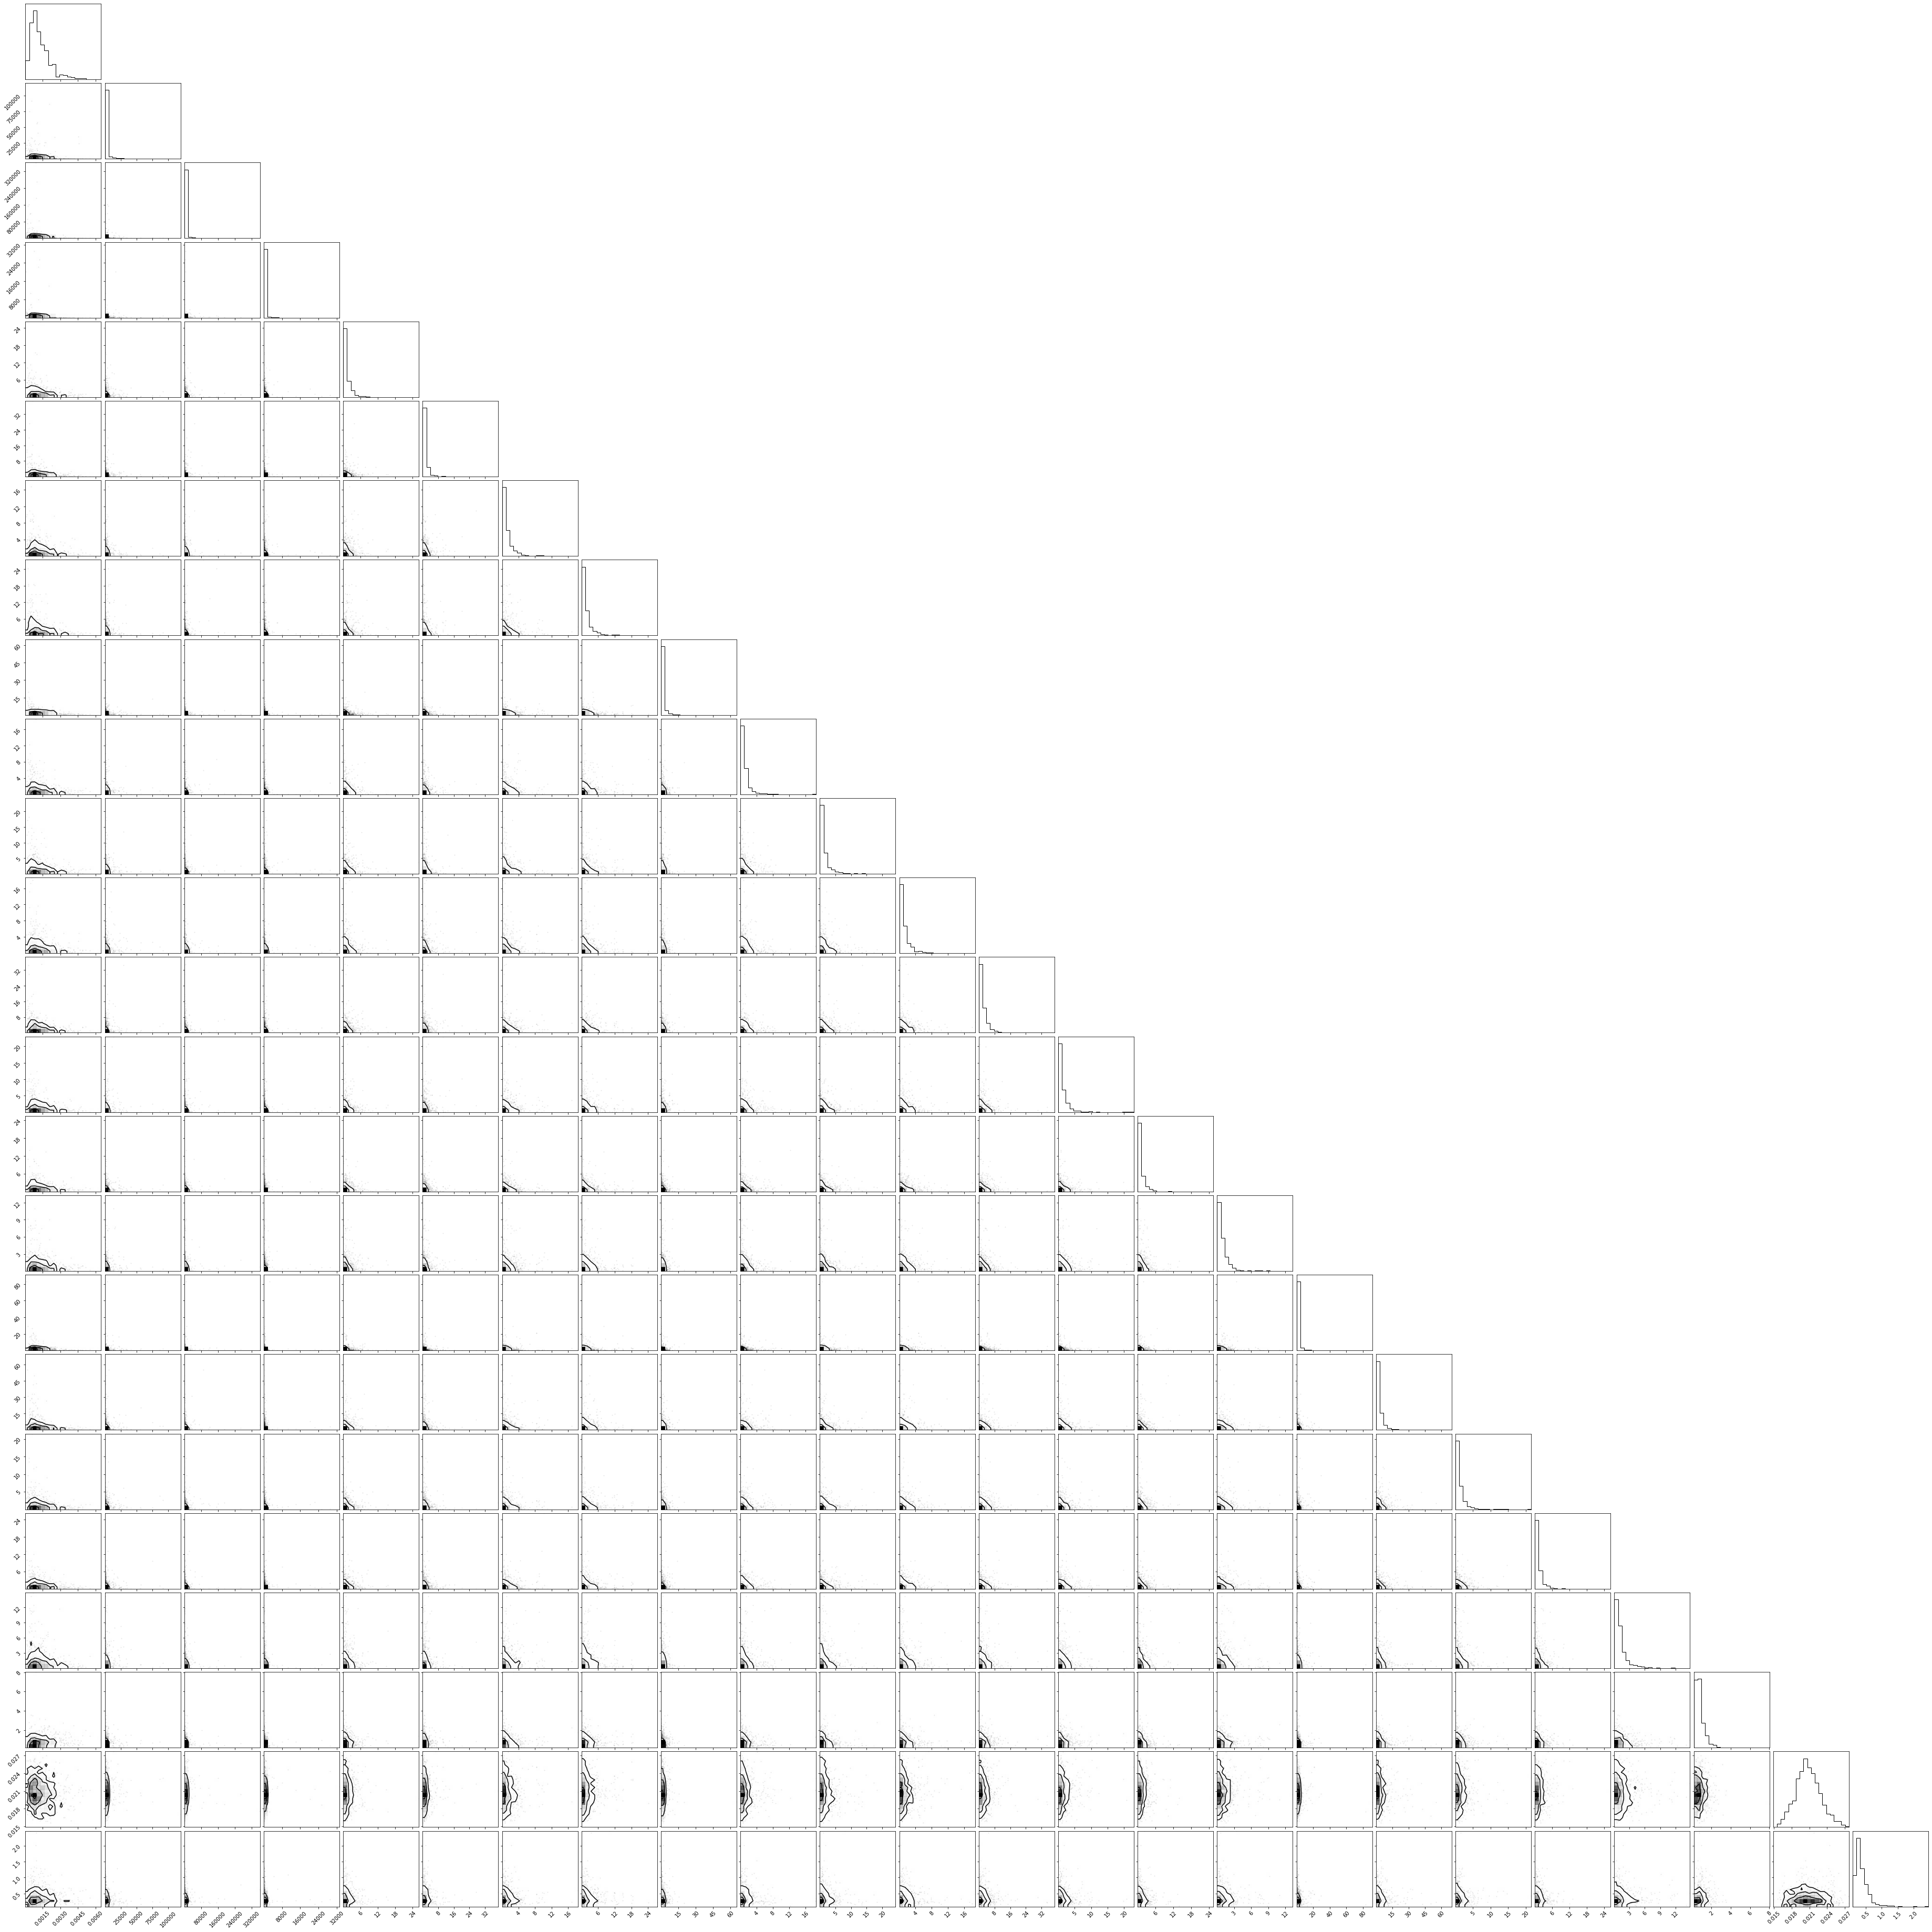

In [144]:
samples = mcmc.get_samples()
#idk why but i cant get corner working with just the mcmc object
corner_samps = []
param_names = 
for param in samples:
    param_names.append([param for param in samples[param].shape(1)])
    corner_samps.append(samples[param].T)

corner_samps = np.vstack(np.array(corner_samps).T)
fig = corner.corner(corner_samps.T, quiet=True) #suppresses warnings about small dataset

In [8]:
'''
ORIGINAL MAIN CODE
'''

def main(args):
    X, Y, expected_thetas, expected_pairwise = get_data(
        N=args.num_data, P=args.num_dimensions, S=args.active_dimensions
    )

    # setup hyperparameters
    hypers = {
        "expected_sparsity": max(1.0, args.num_dimensions / 10),
        "alpha1": 3.0,
        "beta1": 1.0,
        "alpha2": 3.0,
        "beta2": 1.0,
        "alpha3": 1.0,
        "c": 1.0,
    }

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
        jnp.arange(args.num_dimensions)
    )

    print(
        "Coefficients theta_1 to theta_%d used to generate the data:"
        % args.active_dimensions,
        expected_thetas,
    )
    print(
        "The single quadratic coefficient theta_{1,2} used to generate the data:",
        expected_pairwise,
    )
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print(
            "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
            % (dim + 1, args.num_dimensions, inactive, mean, std)
        )

    print(
        "Identified a total of %d active dimensions; expected %d."
        % (len(active_dimensions), args.active_dimensions)
    )

    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(active_dimensions) > 0:
        dim_pairs = jnp.array(
            list(itertools.product(active_dimensions, active_dimensions))
        )
        means, stds = vmap(
            lambda dim_pair: analyze_pair_of_dimensions(
                samples, X, Y, dim_pair[0], dim_pair[1], hypers
            )
        )(dim_pairs)
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            lower, upper = mean - 3.0 * std, mean + 3.0 * std
            if not (lower < 0.0 and upper > 0.0):
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))

        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.
        thetas = sample_theta_space(
            X,
            Y,
            active_dimensions,
            samples["msq"][-1],
            samples["lambda"][-1],
            samples["eta1"][-1],
            samples["xisq"][-1],
            hypers["c"],
            samples["sigma"][-1],
        )
        print("Single posterior sample theta:\n", thetas)


if __name__ == "__main__":
    assert numpyro.__version__.startswith("0.11.0")
    parser = argparse.ArgumentParser(description="Gaussian Process example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    parser.add_argument("--num-warmup", nargs="?", default=500, type=int)
    parser.add_argument("--num-chains", nargs="?", default=1, type=int)
    parser.add_argument("--num-data", nargs="?", default=100, type=int)
    parser.add_argument("--num-dimensions", nargs="?", default=20, type=int)
    parser.add_argument("--active-dimensions", nargs="?", default=3, type=int)
    parser.add_argument("--device", default="cpu", type=str, help='use "cpu" or "gpu".')
    #ipy seems to want a "-f" arg, so this is my fix atm
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    args = parser.parse_args()

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main(args)

sample: 100%|██████████| 1500/1500 [01:11<00:00, 20.98it/s, 15 steps of size 1.77e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.00    382.93      1.00
 lambda[0]   2667.13   7673.19    858.44     68.01   4913.02    623.58      1.00
 lambda[1]   4813.62  22046.76   1161.62     66.84   6606.99    386.81      1.01
 lambda[2]    467.17   1987.94    193.31     25.98    614.06    205.98      1.01
 lambda[3]      1.22      1.73      0.71      0.00      2.92    800.63      1.00
 lambda[4]      1.31      2.26      0.75      0.01      2.67    756.16      1.00
 lambda[5]      1.23      1.63      0.73      0.00      2.91    904.83      1.00
 lambda[6]      1.85      2.64      1.03      0.00      4.29    490.63      1.00
 lambda[7]      1.46      2.68      0.87      0.00      3.11    792.27      1.00
 lambda[8]      1.11      1.58      0.66      0.00      2.43    743.63      1.00
 lambda[9]      1.47      2.13      0.81      0.01      3.49   1050.65      1.00
lambda[10]      1.31      1

**Copied from above for reference:**
The last step of their example analysis (sampling from the posterior with the method `sample_theta_space`) often returns `nan`s. It also reports the posterior for all $\theta$ (active and inactive ones), and only for one sample at a time. That's really clunky. Modify this function to produce valid posterior samples of $\theta$ from all the $\tau$ samples from the MCMC step, but restrict yourself to the active direct and pairwise interaction terms. 

**Visualize the posterior from the example with `corner`.**

### Application (5pts)

Find an application from your area of research where the kernel-interaction method is directly applicable, or could be applied with some modification. Describe the application for a statistically knowledgeable but non-expert audience (think: your peers in SML 505). In particular, explain why the sparse interaction ansatz is justified. Then demonstrate the use with a suitable data set of your own choice. Explain what you find.

This task has three parts:

* Identify and descuss which possible effects there could be.
* Find suitable data.
* Perform the inference and interpret the results.

You will probably need to iterate and refine along the way. Explain your reasoning about the kinds of features you decided to include in your analysis. Then report the most important direct and pairwise interactions. Visualized the posterior samples with `corner`.

**Note:** This is an exploratory study. If your approach is sound, but the data don't show firm trends, points will be awarded. Make sure that you have permission to use the data and include it as separate file in your submission.

**Hint:** Don't forget to standardize the data by subtracting the mean and dividing by the standard deviation.

# NEW SINGLE CELL DATA.

In [159]:
import os
from glob import glob
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
def load_data(data_path):
    data = {}
    nwb = NWBHDF5IO(data_path, mode='r').read()
    trial_info = nwb.intervals['trials']
    data['subj'] = nwb.subject.subject_id
    data['description'] = nwb.experiment_description
    data['rois'] = np.asarray(nwb.electrodes['location'].data)
    data['confidence'] = np.array(trial_info.response_value.data)
    data['condition'] = np.array(trial_info.stim_phase)
    data['category'] = np.array(trial_info.stimCategory.data)
    data['onset'] = np.array(trial_info.start_time.data)
    data['recog_novelty'] = np.array(trial_info.new_old_labels_recog)
    data['unit_electrodes'] = np.array(nwb.units['electrodes'].data)
    # Convert the spike times to stimulus spike counts.
    n_units = data['unit_electrodes'].shape[0]
    n_stimuli = data['category'].shape[0]
    spike_counts = np.zeros([n_stimuli, n_units])
    for i in range(n_units):
        spks = nwb.units.get_unit_spike_times(i)
        spike_counts[:,i] = np.array([((spks>onset)&(spks<onset+1)).sum() for onset in data['onset']+.2])
    data['spike_counts'] = zscore(spike_counts, 0)
    return data

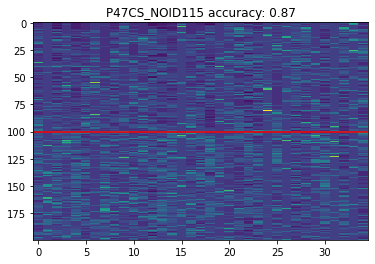

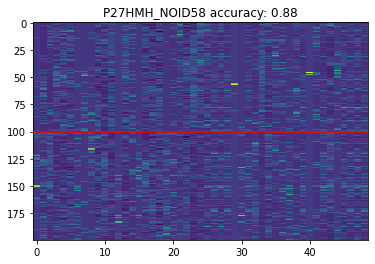

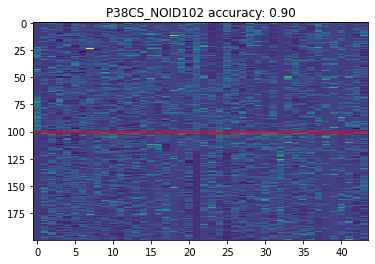

In [161]:
%matplotlib inline
good_sessions = ['P47CS_NOID115', 'P27HMH_NOID58', 'P38CS_NOID102']
nwb_paths = [os.path.join('./', f'data/{session}.nwb') for session in good_sessions] 

all_scores = []
for path in nwb_paths:
    # Load the data.
    data = load_data(path)
    # Evaluate the quality of the data.
    subj = data['subj']
    X, y = data['spike_counts'], (data['condition']=='recog').astype(int)
    clf = svm.SVC(kernel='linear', C=1, random_state=88)
    scores = cross_val_score(clf, X, y, cv=10)
    session = path.split('/')[-1].split('.')[0]
    all_scores.append(scores.mean())
    plt.imshow(data['spike_counts'], aspect='auto', interpolation='none')
    plt.title(f'{session} accuracy: {scores.mean():.2f}')
    plt.axhline(100, c='red')
    plt.show()

In [199]:
X = np.subtract(data['spike_counts'],data['spike_counts'].mean(0))
X = np.divide(X, data['spike_counts'].std(0))
print(data['spike_counts'])
print(np.sum(data['spike_counts']-X))

[[-0.5365816  -0.77915234  0.4891597  ... -0.459841    1.6323035
   1.01468539]
 [-0.5365816   0.17103344  1.77220155 ... -0.459841   -1.00754044
  -0.56459148]
 [-0.5365816  -0.77915234 -0.15236122 ... -0.459841    0.31238153
   0.22504695]
 ...
 [-0.5365816   1.12121922 -1.11464261 ...  1.45616316 -1.00754044
   1.01468539]
 [-0.5365816   0.17103344 -0.15236122 ... -0.459841    0.75235552
  -0.56459148]
 [-0.5365816   0.17103344 -1.11464261 ...  5.28817149 -0.56756645
  -1.35422992]]
4.915789997284037e-13


NameError: name 'N' is not defined

In [201]:

args = argparse.Namespace()
args.num_samples = 1000
args.num_warmup = 500
args.num_chains = 1
args.num_data = 100
args.num_dimensions = 20
args.active_dimensions = 3
args.device = "cpu"
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

#try to predict condition from spike counts
# demean and divide by std column-wise
X = np.subtract(data['spike_counts'],data['spike_counts'].mean(0))
X = np.divide(X, data['spike_counts'].std(0))

Y = jnp.array(data['condition']=='learn',dtype=int)

# setup hyperparameters
hypers = {
    "expected_sparsity": max(1.0, args.num_dimensions / 10),
    "alpha1": 3.0,
    "beta1": 1.0,
    "alpha2": 3.0,
    "beta2": 1.0,
    "alpha3": 1.0,
    "c": 1.0,
}

# do inference
rng_key = random.PRNGKey(0)
mcmc = run_inference(model, args, rng_key, X, Y, hypers)
samples = mcmc.get_samples()


# compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
    jnp.arange(args.num_dimensions)
)

# print(
#     "Coefficients theta_1 to theta_%d used to generate the data:"
#     % args.active_dimensions,
#     expected_thetas,
# )
# print(
#     "The single quadratic coefficient theta_{1,2} used to generate the data:",
#     expected_pairwise,
# )

active_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        active_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, args.num_dimensions, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions; expected %d."
    % (len(active_dimensions), args.active_dimensions)
)

# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.
if len(active_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(active_dimensions, active_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X, Y, dim_pair[0], dim_pair[1], hypers
        )
    )(dim_pairs)
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))

    # Draw a single sample of coefficients theta from the posterior, where we return all singleton
    # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
    # final MCMC sample obtained from the HMC sampler.
    thetas = sample_theta_space(
        X,
        Y,
        active_dimensions,
        samples["msq"][-1],
        samples["lambda"][-1],
        samples["eta1"][-1],
        samples["xisq"][-1],
        hypers["c"],
        samples["sigma"][-1],
    )
    print("Single posterior sample theta:\n", thetas)

sample: 100%|██████████| 1500/1500 [04:40<00:00,  5.36it/s, 15 steps of size 1.78e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.01      0.00      0.01      0.00      0.01    317.28      1.00
 lambda[0]     46.29    106.98     28.67      5.10     82.45    357.18      1.00
 lambda[1]      0.91      1.13      0.61      0.00      2.02   1221.78      1.00
 lambda[2]      0.83      0.83      0.61      0.00      1.82   1514.26      1.00
 lambda[3]      0.90      0.96      0.64      0.00      2.05   1385.51      1.00
 lambda[4]      0.91      1.12      0.62      0.00      1.87    854.76      1.00
 lambda[5]      3.77      3.34      3.02      0.01      7.60    872.28      1.00
 lambda[6]      1.24      1.35      0.83      0.00      2.84   1332.11      1.00
 lambda[7]      0.91      0.96      0.61      0.00      2.10   1042.51      1.00
 lambda[8]      2.04      3.26      1.28      0.00      4.42    988.53      1.00
 lambda[9]      1.63      2.18      0.93      0.00      3.82    835.17      1.00
lambda[10]      1.03      1

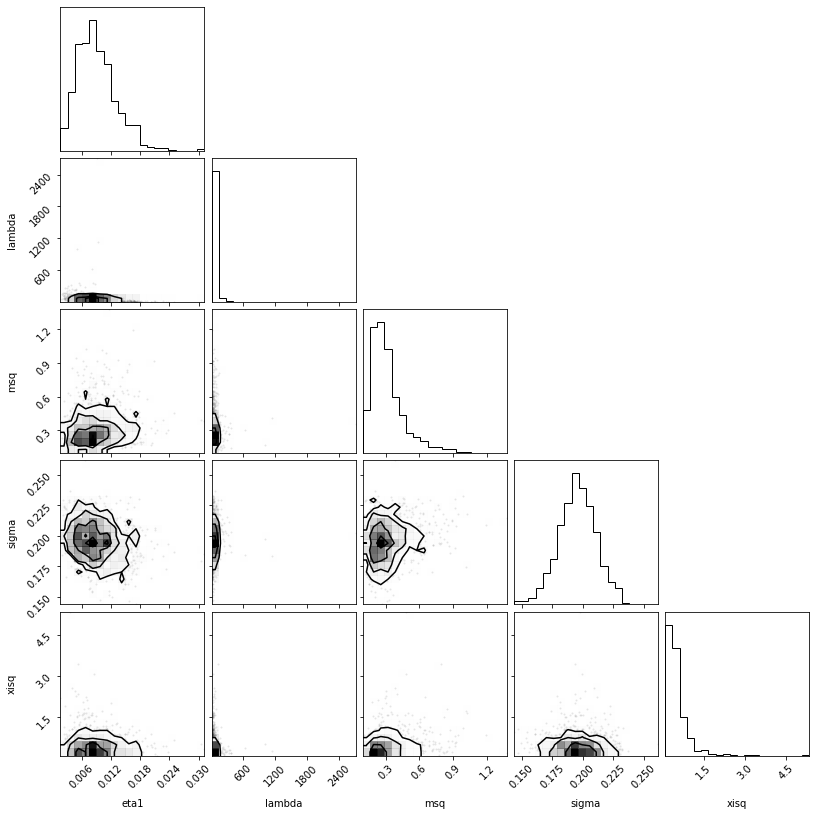

In [218]:
# plot a reduced corner plot with only 1 lambda

samples = mcmc.get_samples()
#idk why but i cant get corner working with just the mcmc object
corner_samps = []
for param in samples:
    if param == 'lambda':
        corner_samps.append(samples[param][:,0])
    else:
        corner_samps.append(samples[param])

corner_samps = np.vstack(np.array(corner_samps))
fig = corner.corner(corner_samps.T, quiet=True, labels=list(samples.keys())) #suppresses warnings about small dataset

In [174]:
Th

samples = mcmc.get_samples()
#idk why but i cant get corner working with just the mcmc object
corner_samps = []
for param in samples:
    corner_samps.append(samples[param].T)

corner_samps = np.vstack(np.array(corner_samps).T)
fig = corner.corner(corner_samps.T, quiet=True) #suppresses warnings about small dataset

/tmp/ipykernel_85422/4025570538.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corner_samps = np.vstack(np.array(corner_samps).T)


# OLD STUFF FOR Multiregion Photometry 

In [12]:
import pickle
def open_sessions(path):
    with open(path, 'rb') as handle:
        feats = pickle.load(handle)
    return feats

In [13]:
#giving it a shot with the multiregion photometry data
big_data = open_sessions('traces_with_labels.pickle')
test_feat = big_data['3095_d1_balbc_t1']

# testing with 20 samples from one animal
indices = np.linspace(0,len(test_feat)-1,20, dtype=int)
test_data = test_feat.loc[indices]


In [14]:
test_data

PrL (E)   PrL (I)   vLS (E)   vLS (I)   POA (E)   POA (I)  BNST (E)  \
0      0.681607  0.894658 -0.888269 -0.843799 -0.340110 -1.034221 -0.819493   
1137  -1.131499 -0.560224  0.912818 -0.361478 -0.102704 -0.229564  0.238827   
2274   0.484549  0.592700 -0.285709 -0.926013 -0.810775 -0.790131  0.409871   
3412   0.039115  0.173020  0.305961  0.019039  0.220993  0.455127  0.690154   
4549   0.992195  0.770555 -0.982957  0.344149  1.114159  0.269363 -1.087739   
5686   0.025483  0.062724  0.053418  0.675728 -0.643694 -0.353413  0.537491   
6824   0.248236  0.579944  0.367395 -0.042344 -0.252030  0.200849  0.342493   
7961  -0.123704  0.159992  0.561350 -0.315389  0.814700  0.644595  1.063309   
9098   1.082003  0.724071 -0.354625 -0.241972  0.289289  0.152310  1.055112   
10236 -0.257100 -0.627219 -0.401628 -0.031202 -0.355371 -0.592168 -0.412169   
11373 -0.097231 -0.498349 -0.152696 -0.288276 -0.457591 -0.583297 -0.161341   
12511  0.208763  0.974018 -1.197978  0.116292 -0.295548 -0.490291 -1.214961   
13648 -0.928885  0.051171 -0.197905 -0.125394  0.032190 -0.329042 -0.697117   
14785  0.242525 -0.304955  0.663248  0.276729 -0.413113 -0.030808 -0.144079   
15923 -0.776084 -0.023722 -0.837824 -0.260742 -0.386924 -0.696464 -0.403907   
17060 -0.347890 -1.041270  0.411945  1.855891 -0.216155  0.030264  0.367121   
18197 -0.353532  0.361392  0.683646 -0.231615  0.697776  0.344527  1.104107   
19335 -0.882986  0.156808 -0.255438 -0.122839  0.209797  0.139226  0.032449   
20472  0.295599 -1.084778 -0.052211  0.128222 -0.314214 -0.557756 -0.520227   
21610  0.732333  0.284941 -0.290341 -0.240582  0.654424  0.053687  1.225278   

       BNST (I)    AH (E)    AH (I)   MeA (E)   MeA (I)   VMH (E)   VMH (I)  \
0     -1.648179 -0.129511 -1.166632 -0.772297 -0.993607 -0.569781 -0.558806   
1137   0.176632  1.525768  0.044734  2.956003  1.401380  0.533078  0.804184   
2274  -0.173598 -0.454501 -0.825206 -0.279623 -0.247846  0.046727 -0.796040   
3412   1.034762  0.854707 -0.190598  1.008199  2.165748  0.338722  0.450701   
4549  -0.372527  0.451269  0.627000  0.205808  1.187492  2.132113  0.141790   
5686   0.468040 -0.535161  0.218310 -0.051369 -0.644261 -0.226956 -0.229516   
6824   0.456349 -0.189765 -0.426033 -0.100556  0.290942 -0.419546 -0.446257   
7961   0.096896  0.399559  0.360560 -0.142798 -0.092706  0.516771  0.263140   
9098   0.683706 -0.142590 -0.460642 -0.135942 -0.415465  1.297486 -0.302632   
10236 -0.394028 -0.343196 -0.448032 -0.453459 -0.519170 -0.548355 -0.649050   
11373 -0.002358 -0.488594 -0.346323 -0.489711 -0.252992 -0.583454 -0.478758   
12511 -0.337566  0.023937 -0.247144 -0.378463 -0.198789  1.147852  0.036685   
13648 -0.435686 -0.140341 -0.305107 -0.504775 -0.415336 -0.116899 -0.454832   
14785  0.342790 -0.208985  0.067896 -0.137370 -0.071752  0.274441  0.132644   
15923 -0.417521 -0.445770 -0.516757 -0.193359 -0.348488 -0.324881 -0.458620   
17060  0.022011  0.649434  0.892286  0.535319 -0.402645 -0.495044 -0.320572   
18197  0.234441  0.517857  0.078968  0.761266 -0.128483  0.397919  0.380683   
19335  0.176168  1.435644  0.355071  0.412655  0.333157  0.285428  0.736815   
20472 -0.468606 -0.147382  0.136362  0.841511 -0.495540 -0.592962 -0.484461   
21610  0.723362 -0.019893 -0.090577  0.027090 -0.347064  0.389783 -0.358685   

       NAc (DA)  labels  
0     -1.871317     5.0  
1137   1.335734     4.0  
2274   0.667307     9.0  
3412   1.412627     3.0  
4549  -1.913573     3.0  
5686   0.384150     7.0  
6824   0.884254    10.0  
7961   1.152273     5.0  
9098   0.752234     6.0  
10236 -0.510203     6.0  
11373 -0.403800     7.0  
12511 -0.694727     6.0  
13648 -0.034418     5.0  
14785  0.371764     6.0  
15923 -0.559572     1.0  
17060 -0.588471    10.0  
18197  0.729628     5.0  
19335 -0.857125     2.0  
20472 -0.846511    10.0  
21610 -0.519567    10.0

In [15]:
from sklearn.linear_model import LinearRegression
X = test_feat.values[:, :-2]
y = test_feat.values[:, -2]

inds = np.arange(0, X.shape[0])
np.random.shuffle(inds)
test_inds, train_inds = inds[:1000], inds[1000:]
X_train, X_test, y_train, y_test = X[train_inds], X[test_inds], y[train_inds], y[test_inds]
reg = LinearRegression().fit(X_train,y_train)
y_out = reg.score(X_test, y_test)
print(y_out)


0.6398567636638005


In [18]:
# set up variables with multiregion photom data
def get_multi_data(test_data): #(N=20, S=2, P=10, sigma_obs=0.05):

    #try setting Y as the NAc DA signal, and using the activity in the other regions to predict (as X)
    Y = test_data['NAc (DA)'].to_numpy()
    X = test_data.iloc[:,:14].to_numpy()

    Y -= jnp.mean(Y)
    Y_std = jnp.std(Y)
    print(Y_std)

    return X, Y / Y_std, 0, 1.0 / Y_std

In [19]:
def main_multi(args,test_data):
    X, Y, expected_thetas, expected_pairwise = get_multi_data(test_data)

    # setup hyperparameters
    hypers = {
        "expected_sparsity": max(1.0, args.num_dimensions / 10),
        "alpha1": 3.0,
        "beta1": 1.0,
        "alpha2": 3.0,
        "beta2": 1.0,
        "alpha3": 1.0,
        "c": 1.0,
    }

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
        jnp.arange(args.num_dimensions)
    )

    print(
        "Coefficients theta_1 to theta_%d used to generate the data:"
        % args.active_dimensions,
        expected_thetas,
    )
    print(
        "The single quadratic coefficient theta_{1,2} used to generate the data:",
        expected_pairwise,
    )
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print(
            "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
            % (dim + 1, args.num_dimensions, inactive, mean, std)
        )

    print(
        "Identified a total of %d active dimensions; expected %d."
        % (len(active_dimensions), args.active_dimensions)
    )

    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(active_dimensions) > 0:
        dim_pairs = jnp.array(
            list(itertools.product(active_dimensions, active_dimensions))
        )
        means, stds = vmap(
            lambda dim_pair: analyze_pair_of_dimensions(
                samples, X, Y, dim_pair[0], dim_pair[1], hypers
            )
        )(dim_pairs)
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            lower, upper = mean - 3.0 * std, mean + 3.0 * std
            if not (lower < 0.0 and upper > 0.0):
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))

        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.

        # FOR THE PROJECT
        # Modify this function to produce valid posterior samples of theta from all the tau samples from the MCMC step
        # but restrict yourself to the active direct and pairwise interaction terms
        thetas = sample_theta_space(
            X,
            Y,
            active_dimensions,
            samples["msq"][-1],
            samples["lambda"][-1],
            samples["eta1"][-1],
            samples["xisq"][-1],
            hypers["c"],
            samples["sigma"][-1],
        )
        print("Single posterior sample theta:\n", thetas)


In [ ]:
if __name__ == "__main__":
    assert numpyro.__version__.startswith("0.11.0")
    parser = argparse.ArgumentParser(description="Gaussian Process example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    parser.add_argument("--num-warmup", nargs="?", default=500, type=int)
    parser.add_argument("--num-chains", nargs="?", default=1, type=int)
    parser.add_argument("--num-data", nargs="?", default=100, type=int)
    parser.add_argument("--num-dimensions", nargs="?", default=20, type=int)
    parser.add_argument("--active-dimensions", nargs="?", default=14, type=int)
    parser.add_argument("--device", default="cpu", type=str, help='use "cpu" or "gpu".')
    #ipy seems to want a "-f" arg, so this is my fix atm
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    args = parser.parse_args()

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main_multi(args,test_feat)